# <center>ANALYSIS 4TH CAMPAIGN<center>

In [2]:
%load_ext autoreload
%autoreload 2

In [63]:
import ROOT
import numpy as np
import os
from array import array
from pathlib import Path
import plotly.graph_objects as go
from utils_lib import  wu_rootfile, wu_rootfileList, fromDatafile_fill, getVals, reshape_paramReps
from graph_lib import plot_root_param_xy, plot_WFs

In [ ]:
RAW_DATA = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RawData/"

""" ###################################################################################
FILES = {
    "1MW2": {
        "DEF": [
            {
                "filename": "20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated",
                "subtype": "zscan",
            },
            {
                "filename": "20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated",
                "subtype": "zscan",
            },
        ],
    },

}
""" ###################################################################################

FILES = {
    # CNM ---------------------------------
    "1MW2": {
        "DEF": [
            {"filename": "20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated"},
            {"filename": "20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated"},
        ],
    },
    "F2W1": {
        "DEF": [
            {"filename": ""},
        ],
    },
    "CNM13575": {
        "DEF": [
            {"filename": ""},
        ],
    },

    # SICAR ---------------------------------
    "3W0": {
        "DEF": [
            {"filename": ""},
        ],
    },
    "Sicar1_4_32": {
        "DEF": [
            {"filename": ""},
        ],
    },
    "Sicar1_4_40": {
        "DEF": [
            {"filename": ""},
        ],
    },
        
    # CTU ---------------------------------
    "LGAD1_41": {
        "DEF": [
            {"filename": ""},
        ],
    },
    "LGAD2_35": {
        "DEF": [
            {"filename": ""},
        ],
    },
    "PIN_24": {
        "DEF": [
            {"filename": ""},
        ],
    },    

}  


# <center>ANÁLISIS - 1MW2<center>


#### Generate root files 

In [6]:
IMG_Path_1MW2  = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/"
ROOT_FILES_1MW2 = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RootFiles/1MW2/"
def rf(file_name):
    return f"{ROOT_FILES_1MW2}{file_name}.root"

def ls_rootfile(file_name, tree_name="", max_preview=5):
    """
    max_preview:
      - nº máximo de elementos a mostrar si el vector es pequeño
      - si len(vector) > max_preview → solo se imprime el tamaño
    Si tree_name es "" (default), lista todos los TTrees y muestra sus parámetros.
    """
    import ROOT

    def vector_to_list(obj):
        cls = obj.__class__.__name__ if hasattr(obj, "__class__") else ""
        if "vector" in cls:
            return [vector_to_list(v) for v in obj]
        return obj

    def shape_of_list(value):
        shape = []
        cur = value
        while isinstance(cur, list):
            shape.append(len(cur))
            if len(cur) == 0:
                break
            cur = cur[0]
        return shape

    def format_shape(shape):
        if not shape:
            return ""
        return "".join([f"[{d}]" for d in shape])

    def preview_value(value):
        if isinstance(value, list):
            shape = shape_of_list(value)
            shape_str = format_shape(shape)
            n = len(value)
            if n == 0:
                return f"vector{shape_str} (empty)"
            if n <= max_preview:
                return f"vector{shape_str} {value}"
            return f"vector{shape_str}"
        return value

    def print_tree(t, name):
        print(f"\n--- TTree: {name} (estructura) ---")
        t.Print()

        if t.GetEntries() == 0:
            print("[INFO] Tree sin entradas")
            return

        print(f"\n--- TTree: {name} (valores, entry 0) ---")
        t.GetEntry(0)

        for br in t.GetListOfBranches():
            bname = br.GetName()
            val = getattr(t, bname)
            cls = val.__class__.__name__

            # ---------- vectores (incluye anidados) ----------
            if "vector" in cls:
                list_val = vector_to_list(val)
                preview = preview_value(list_val)
                print(f"{bname} = {preview}")

            # ---------- strings ----------
            elif "string" in cls:
                print(f"{bname} = '{str(val)}'")

            # ---------- escalares ----------
            else:
                print(f"{bname} = {val}")

    def list_trees(file_obj):
        trees = []
        for key in file_obj.GetListOfKeys():
            obj = key.ReadObj()
            if obj.InheritsFrom("TTree"):
                trees.append(obj.GetName())
        return trees

    root_path = rf(file_name)

    f = ROOT.TFile.Open(root_path)
    if not f or f.IsZombie():
        print(f"[ERROR] No se pudo abrir: {root_path}")
        return

    print(f"\n=== Contenido de {root_path} ===")
    f.ls()

    if tree_name == "":
        tree_names = list_trees(f)
        if not tree_names:
            print("[WARNING] No hay TTrees en el archivo")
            f.Close()
            return
        for tname in tree_names:
            t = f.Get(tname)
            if t:
                print_tree(t, tname)
        f.Close()
        return

    t = f.Get(tree_name)
    if not t:
        print(f"[WARNING] No existe el TTree '{tree_name}'")
        f.Close()
        return

    print_tree(t, tree_name)
    f.Close()


# Load base path parameters
filenames = [entry["filename"] for entry in FILES["1MW2"]["DEF"]]
root_files = [ f"{ROOT_FILES_1MW2}{file_name}.root" for file_name in filenames]

In [ ]:

print("DATAFILES:")
for name in filenames:
    outpath = Path(ROOT_FILES_1MW2) / f"{name}.root"
    _nameList = ["dataPath"]
    _dataList = [f"{RAW_DATA}{name}"]
    wu_rootfile(str(outpath), _nameList, _dataList, tree_name="Base")  # si quieres inicializar “vacío”
    
print(filenames)
print("DONE!")

DATAFILES:
['20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated', '20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated']
DONE!


#### Initial fill - WFs + initial parameters



In [11]:
# Load Initial parameters -> Pars
initial_pars = {
  "dt": 0.05,
  "aLPower": 1.00,
}
# Common mods:
for key, value in initial_pars.items():
  wu_rootfileList(root_files, [key], [value],  tree_name="Pars")

# Load From datafile -> Raw 
fromDatafile_fill(filenames, ROOT_FILES_1MW2, RAW_DATA, tree_name="Raw")



{'20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated': {'ok': True,
  'root_path': '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RootFiles/1MW2/20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated.root',
  'raw_path': '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RawData/20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated',
  'n_rows': 330,
  'n_samples': 4000},
 '20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated': {'ok': True,
  'root_path': '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RootFiles/1MW2/20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated.root',
  'raw_path': '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RawData/20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated',
  'n_rows': 330,
  'n_samples': 4000}}

In [12]:
#ls_rootfile(filenames[1])

In [75]:
# Get Raw signals "n_events", "n_samples", "events", "t"
for _rp in root_files:
    vals = getVals(_rp, ["Raw:WFsRaw", "Pars:dt"])

    WFsRaw = vals["Raw:WFsRaw"]
    dt = float(vals["Pars:dt"])

    n_events = WFsRaw.shape[0]
    n_samples = WFsRaw.shape[1] if WFsRaw.ndim > 1 else 0

    events = np.arange(n_events, dtype=np.int32)
    t = np.arange(n_samples, dtype=np.int32) * dt

    wu_rootfile(
        _rp,
        ["n_events", "n_samples", "events", "t"],
        [n_events, n_samples, events, t],
        tree_name="Raw",
    )

    reshape_paramReps(_rp, "Raw:z")


print("DONE!")


DONE!


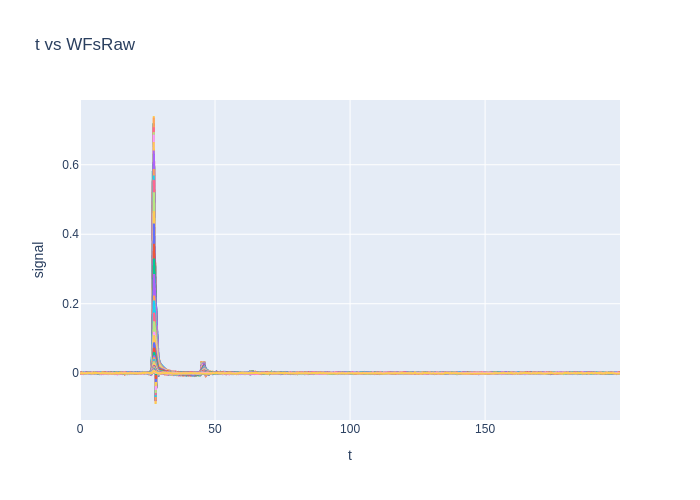

('/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_WFsRaw.png',
 '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_WFsRaw.html')

In [31]:
# Print WFs to get idea of RAW signals initial parameters
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="t_vs_WFsRaw",
    root_files=[root_files[0]],
    x_param="Raw:t",
    y_param="Raw:WFsRaw",
    labels=["t vs WFsRaw", "t", "signal"],
    show=True,
    style="line",
)

In [ ]:
# Visual analysis of WFs 
_nameList = ["aTBL", "aTLeft", "aTRight"]
_dataList = [25, 26.55, 44.0]
wu_rootfileList(root_files, _nameList, _dataList, tree_name="Raw")

In [16]:
#ls_rootfile(filenames[1])

### <center>ANALYSIS BLOCK</center>

In [85]:
from analysis_lib import analyze_wfsraw, get_signalsROI, correct_Signals
# Calculation of individual BLLevel TLeft and TRight
for _rp in root_files:
    analyze_wfsraw(_rp)
    get_signalsROI(_rp)
    correct_Signals(_rp, mode = "COR")

print("DONE!")

DONE!


In [8]:
show_file = root_files[1] 

#### ROI SIGNALS

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_SignalsRoi.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_SignalsRoi.html


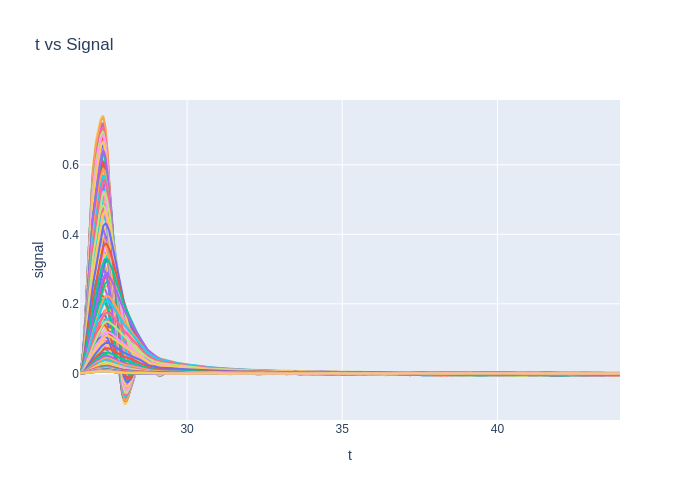

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_SignalsMaskedRoi.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/t_vs_SignalsMaskedRoi.html


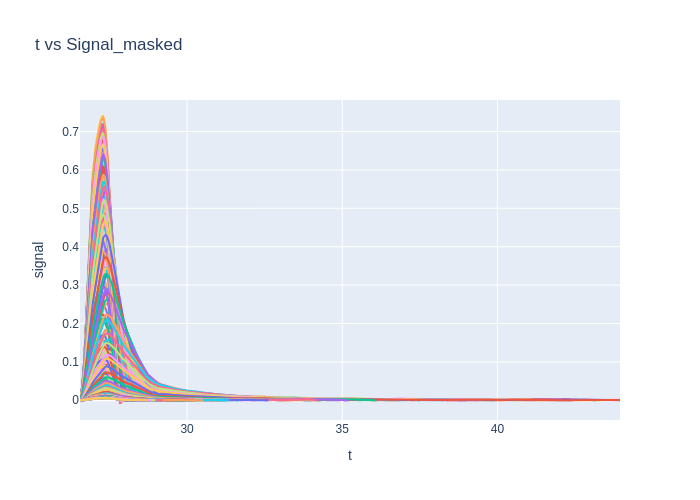

DONE!


In [ ]:
# Print ROI signals
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="t_vs_SignalsRoi",
    root_files=[show_file],
    x_param="Signal:t",
    y_param="Signal:signals",
    labels=["t vs Signal", "t", "signal"],
    show=True,
    style="line",
)

# Print ROI signals
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="t_vs_SignalsMaskedRoi",
    root_files=[show_file],
    x_param="Signal:t",
    y_param="Signal:signals_masked",
    labels=["t vs Signal_masked", "t", "signal"],
    show=True,
    style="line",
)

print("DONE!")

### CHARGE

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_raw_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_raw_flat.html


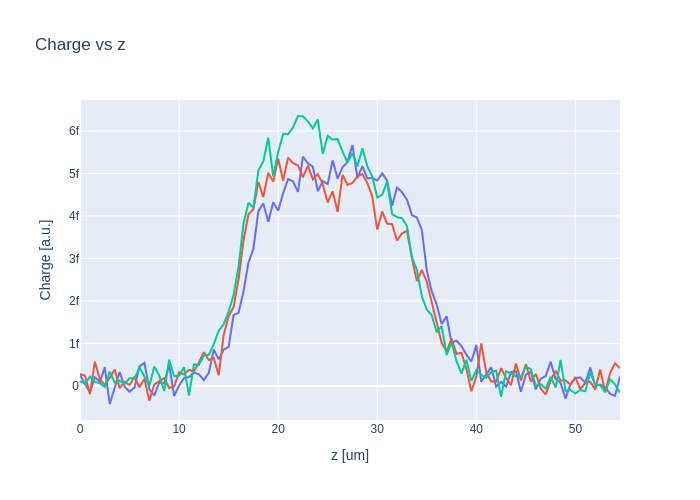

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_roi_raw_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_roi_raw_flat.html


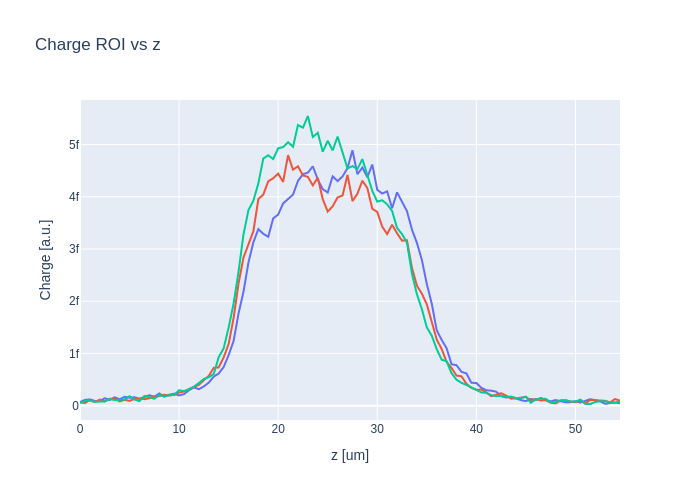

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_roi_mask_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_roi_mask_flat.html


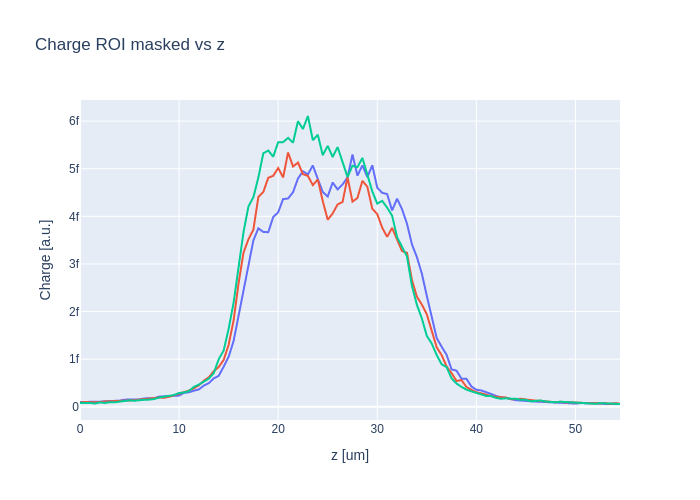

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_flat.html


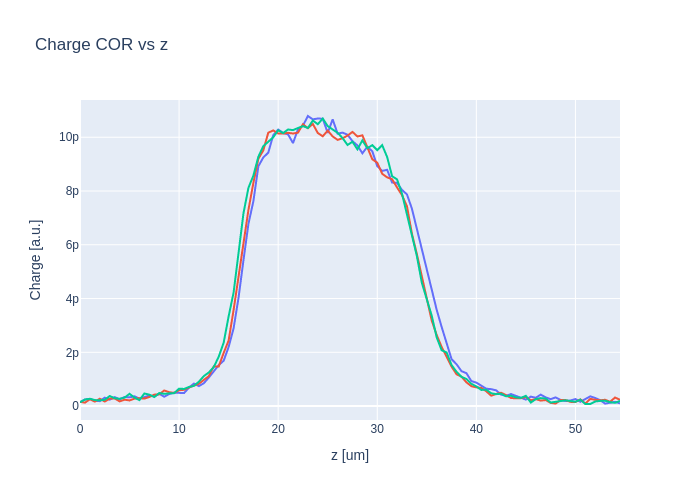

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_flat.html


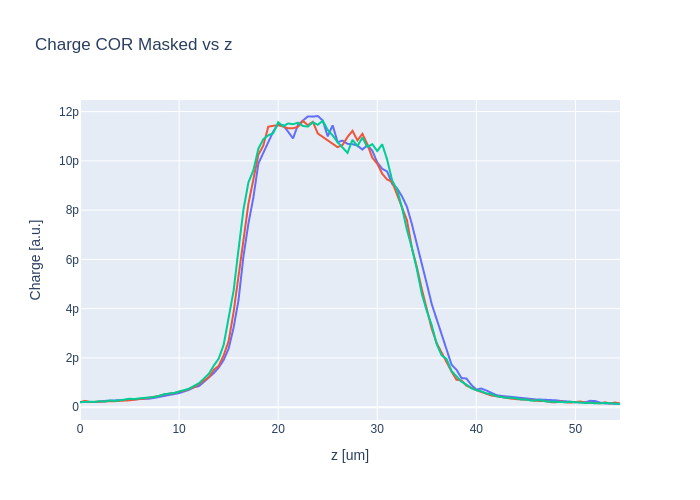

DONE!
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_avr_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_avr_flat.html


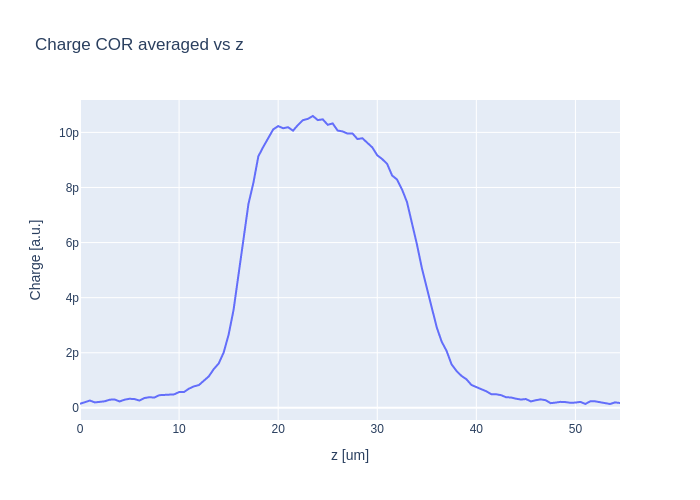

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_avr_flat.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/charge_COR_masked_avr_flat.html


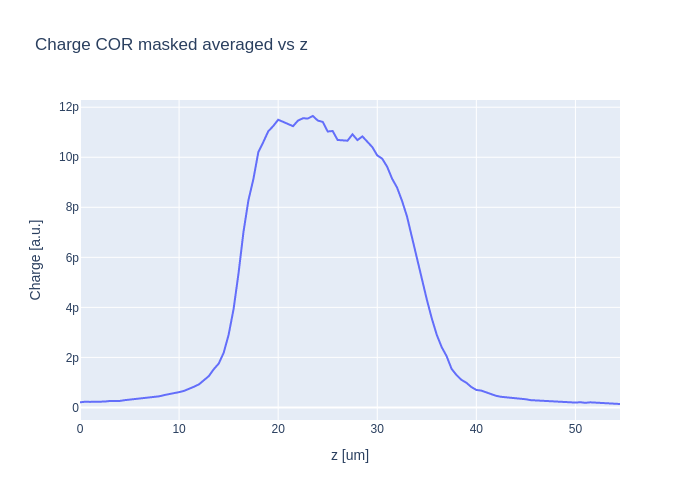

DONE!


In [9]:
from analysis_lib import integrate_charge

unitfactor = 0.05e-9 / 50 / 100 # dt NS / Ohms / Gain
for _rp in root_files:
    integrate_charge(_rp, "Raw:t",    "Raw:WFsRaw",               saveto= "Charge:Raw"         ,unitfactor=unitfactor,)
    integrate_charge(_rp, "Signal:t", "Signal:signals",           saveto= "Charge:Roi"         ,unitfactor=unitfactor,)
    integrate_charge(_rp, "Signal:t", "Signal:signals_masked",    saveto= "Charge:Roi_masked"   ,unitfactor=unitfactor,)
    integrate_charge(_rp, "Signal:t", "Signal:signals_COR",       saveto= "Charge:COR"         ,unitfactor=unitfactor,)
    integrate_charge(_rp, "Signal:t", "Signal:signals_COR_masked",saveto= "Charge:COR_masked"  ,unitfactor=unitfactor,)

    reshape_paramReps(_rp, "Charge:Raw")
    reshape_paramReps(_rp, "Charge:Roi")
    reshape_paramReps(_rp, "Charge:Roi_masked")
    reshape_paramReps(_rp, "Charge:COR")
    reshape_paramReps(_rp, "Charge:COR_masked")


# RAW
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_raw_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:Raw_R",
    labels=["Charge vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

# ROI
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_roi_raw_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:Roi_R",
    labels=["Charge ROI vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

# ROI - masked
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_roi_mask_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:Roi_masked_R",
    labels=["Charge ROI masked vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

# COR - masked
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_COR_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:COR_R",
    labels=["Charge COR vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

# COR - masked
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_COR_masked_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:COR_masked_R",
    labels=["Charge COR Masked vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

print("DONE!")

# COR - aver
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_COR_masked_avr_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:COR_A",
    labels=["Charge COR averaged vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)

# COR - masked aver
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="charge_COR_masked_avr_flat",
    root_files=[show_file],
    x_param="Raw:z_A",
    y_param="Charge:COR_masked_A",
    labels=["Charge COR masked averaged vs z", "z [um]", "Charge [a.u.]"],
    show=True,
    style="line",
)
print("DONE!")

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/TRight.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/TRight.html


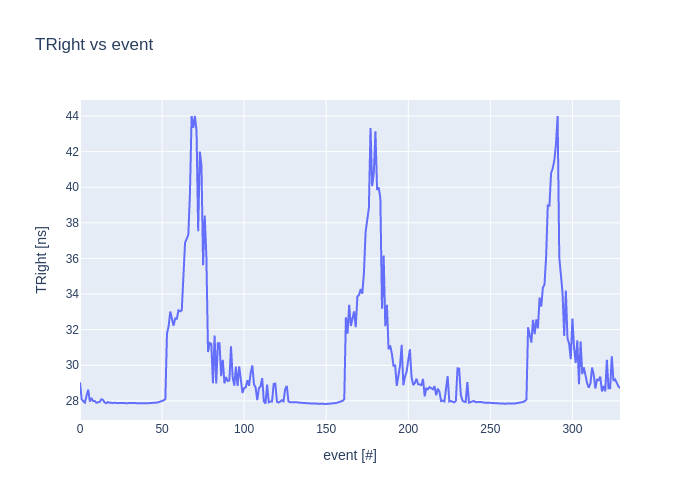

/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/Charge.png
/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/Images/1MW2/Charge.html


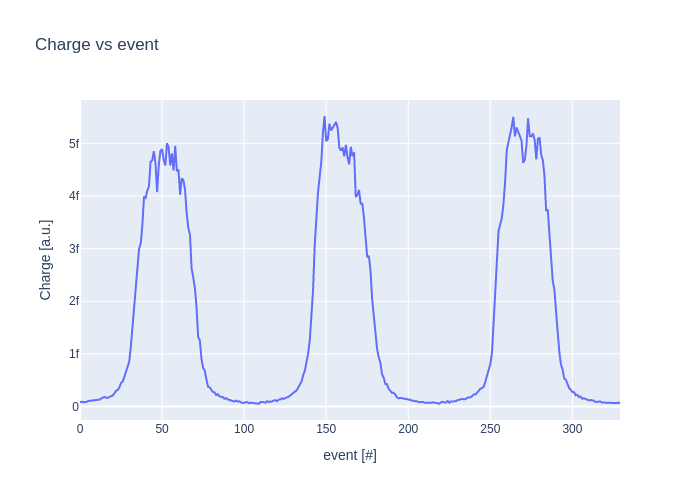

{'Signal:TRight': array([29.0431943 , 28.08830103, 27.9810937 , 27.90131149, 28.29024974,
       28.63181731, 27.96364134, 28.15811046, 27.98608008, 27.98857328,
       27.89383191, 27.90131149, 27.94369579, 28.09079423, 28.05838271,
       27.90879107, 27.86889997, 27.93372301, 27.89133872, 27.8988183 ,
       27.87388636, 27.90131149, 27.86889997, 27.86889997, 27.88136594,
       27.87139316, 27.89383191, 27.88136594, 27.88136594, 27.86889997,
       27.87887275, 27.87388636, 27.87887275, 27.87388636, 27.87388636,
       27.87637955, 27.86640678, 27.86640678, 27.87139316, 27.86640678,
       27.86391358, 27.86640678, 27.86640678, 27.87388636, 27.87887275,
       27.88635233, 27.8988183 , 27.90629788, 27.92873662, 27.95117537,
       27.98358689, 28.03095757, 28.09827381, 31.79069398, 32.1945914 ,
       33.01734538, 32.61594117, 32.22450972, 32.63090033, 32.61344797,
       33.08466162, 33.03230455, 33.07967523, 34.92463872, 36.87930274,
       37.10369019, 37.32807764, 39.69411866, 

In [72]:
# 
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="TRight",
    root_files=[root_files[0]],
    x_param="Raw:events",
    y_param="Signal:TRight",
    labels=["TRight vs event", "event [#]", "TRight [ns]"],
    show=True,
    style="line",
)

# 
plot_root_param_xy(
    out_dir=IMG_Path_1MW2,
    out_name="Charge",
    root_files=[root_files[0]],
    x_param="Raw:events",
    y_param="Charge:RoiMasked",
    labels=["Charge vs event", "event [#]", "Charge [a.u.]"],
    show=True,
    style="line",
)

print(getVals(root_files[0], ["Signal:TRight"]))

In [64]:
from analysis_lib import zscan_profileAnalisis

for _rp in root_files:
    zscan_profileAnalisis(_rp, "Charge:COR")

fig = go.Figure()
for _rp in root_files:
    vals = getVals(_rp, ["zscan:zcharge"])
    zcharge = np.asarray(vals["zscan:zcharge"])

    fig.add_trace(
                    go.Scatter(x=zcharge[0, :], y=zcharge[1, :], 
                               mode="markers", showlegend=False)
                )

fig.show()

for _rp in root_files:
    fig = go.Figure()

    vals = getVals(_rp, ["Charge:COR_R","Raw:reps","Raw:z_A", "zscan:z0"])
    charge = np.asarray(vals["Charge:COR_R"])
    reps = vals["Raw:reps"]
    z = np.asarray(vals["Raw:z_A"])
    z0 = np.asarray(vals["zscan:z0"])

    for i in range(reps):
        fig.add_trace(go.Scatter(x=z-z0[i], y=charge[i, :], mode="markers", showlegend=False))
                        
                    

    fig.show()

20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated
Param z0 = [17.28970334 16.40191278 16.64296006]
Param Rl = [1.37001299 1.28777392 1.02315424]
Param spa = [-1.82062711e-13 -1.39529045e-13 -8.18911600e-15]
Param FWHM = [17.00955414 17.55505005 17.3566879 ]


20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated
Param z0 = [16.54816934 16.28213995 15.92123509]
Param Rl = [1.15347263 1.15228967 1.16700353]
Param spa = [-5.94433382e-14 -7.90514282e-14 -7.07052023e-14]
Param FWHM = [18.2989081  18.05095541 18.19972702]


In [76]:
plot_WFs(root_files[0], "Signal:signals_COR", 
         legend_pars=["Raw:maxV", "Raw:z"], cut_limits=["Raw:z;20;21"], 
         colormap_val = "cividis",
         )

## ANALYSIS